# Baseline Tests

Here we test some standard models like random forest and naive Bayes to establish some baseline for the project.

In [2]:
import os

import imageio
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, cohen_kappa_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB

from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
data_dir = "../data"

selected_columns = ["Type", "Age", "Breed1", "Breed2", "Gender", "Color1", "Color2", "Color3",
                    "MaturitySize", "FurLength", "Vaccinated", "Dewormed", "Sterilized", "Health",
                    "Quantity", "Fee", "State", "VideoAmt", "PhotoAmt", "Description"]

label_column = "AdoptionSpeed"

In [24]:
# Read train.csv
# TODO: rm n-rows
train = pd.read_csv(os.path.join(data_dir, "train.csv"), sep=',')
pet_ids = train["PetID"]

In [25]:
y = train["AdoptionSpeed"]
X = train[selected_columns]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [27]:
def normalize(df, columns):
    result = df.copy()
    for feature_name in columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [28]:
X_train_norm = normalize(X_train, ["Age", "Fee"]) #, "Quantity", "VideoAmt", "PhotoAmt"])
X_test_norm = normalize(X_test, ["Age", "Fee"]) # ,"Quantity", "VideoAmt", "PhotoAmt"])

In [29]:
X_dummies = pd.get_dummies(X, columns=["Type", "Breed1", "Breed2", "Gender", "Color1", "Color2", "Color3", "MaturitySize", 
                                       "FurLength", "Vaccinated", "Dewormed", "Sterilized", "Health", "State"])

In [30]:
X_train_dummies, X_test_dummies, y_train, y_test = train_test_split(X_dummies, y, test_size=0.3, random_state=1)

In [72]:
import numbers
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer



max_features = 200

texts_train = [x.lower() if not isinstance(x, numbers.Real) else "" for x in X_train_dummies.Description]
# Remove punctuation
texts_train = [''.join(c for c in x if c not in string.punctuation) for x in texts_train]
# Remove numbers
texts_train = [''.join(c for c in x if c not in '0123456789') for x in texts_train]
# Trim extra whitespace
texts_train = [' '.join(x.split()) for x in texts_train]




test_texts = [x.lower() if not isinstance(x, numbers.Real) else "" for x in X_test_dummies.Description]
# Remove punctuation
test_texts = [''.join(c for c in x if c not in string.punctuation) for x in test_texts]
# Remove numbers
test_texts = [''.join(c for c in x if c not in '0123456789') for x in test_texts]
# Trim extra whitespace
test_texts = [' '.join(x.split()) for x in test_texts]




# Define tokenizer
def tokenizer(text):
    words = nltk.word_tokenize(text)
    return words

# Create TF-IDF of texts
tfidf = TfidfVectorizer(tokenizer=tokenizer, stop_words='english', max_features=max_features, ngram_range=(1,3),
                       max_df=1.0, min_df=1)
sparse_tfidf_texts = tfidf.fit_transform(texts_train)


test_sparse_tfidf_texts = tfidf.transform(test_texts)

In [93]:


train_df = pd.DataFrame(sparse_tfidf_texts.toarray(), columns=tfidf.get_feature_names(), index=X_train_dummies.index)
test_df = pd.DataFrame(test_sparse_tfidf_texts.toarray(), columns=tfidf.get_feature_names(), index=X_test_dummies.index)





In [94]:
X_train_dummies

,Age,Quantity,Fee,VideoAmt,PhotoAmt,Description,Type_1,Type_2,Breed1_0,Breed1_1,...,State_41330,State_41332,State_41335,State_41336,State_41342,State_41345,State_41361,State_41367,State_41401,State_41415
11539,2,1,0,0,1.0,Chilli is an active boy who was rescued off th...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6945,1,1,30,0,7.0,"I found her in front of my office, inside a bo...",1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12403,1,1,0,0,2.0,A mother dog delivered a litter of 6 pups outs...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3259,7,2,500,0,1.0,A pair of Shih Tzu for adoption. Bobby (Male) ...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1125,10,1,110,0,2.0,Sweet girl. Desperate to come out from the enc...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10940,4,1,0,0,2.0,This sweet little girl is very lively and curi...,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2617,4,4,0,0,17.0,"Miu Ciu, Small Black, Teleng & Orengy are abou...",0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11410,2,1,0,0,2.0,"Panda is rescue at kulai ,now.healthy n smart....",1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
11979,7,1,0,0,3.0,"I rescued her from street, It was 5 months ago...",0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
518,12,1,0,0,5.0,i'm looking for a new owner for my cat A.S.A.P...,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
X_train_new = pd.concat([X_train_dummies, train_df], axis=1)
X_test_new = pd.concat([X_test_dummies, test_df], axis=1)


In [104]:
# importances = forest.feature_importances_

# Code taken from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
def plot_feature_importances(forest, importances, features):
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    print("Feature list:", list(features))
    print()

    # Print the feature ranking
    print("Feature ranking:")
    
    n_features = len(features)
    for i in range(n_features): # range(X.shape[1]):
        print("%d. feature %s (%f)" % (i + 1, features[indices[i]], importances[indices[i]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(n_features), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(n_features), indices)
    plt.xlim([-1, n_features])
    plt.show()

In [105]:
X_train_new = X_train_new.drop("Description", axis=1)
X_test_new = X_test_new.drop("Description", axis=1)

In [98]:
X_train_new

,Age,Quantity,Fee,VideoAmt,PhotoAmt,Type_1,Type_2,Breed1_0,Breed1_1,Breed1_3,...,week,weeks,whatsapp,white,willing,wish,yang,year,years,young
11539,2,1,0,0,1.0,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.474761,0.000000,0.000000,0.000000,0.000000
6945,1,1,30,0,7.0,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.365351
12403,1,1,0,0,2.0,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.190633,0.000000,0.000000,0.000000,0.000000,0.000000
3259,7,2,500,0,1.0,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1125,10,1,110,0,2.0,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10940,4,1,0,0,2.0,0,1,0,0,0,...,0.000000,0.000000,0.000000,0.476559,0.125708,0.000000,0.000000,0.135514,0.000000,0.000000
2617,4,4,0,0,17.0,0,1,0,0,0,...,0.000000,0.000000,0.000000,0.244565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11410,2,1,0,0,2.0,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11979,7,1,0,0,3.0,0,1,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
518,12,1,0,0,5.0,0,1,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 1. Random Forest

First, try changing n_estimators to find the best one according to test score.

In [108]:
best_test_score = -1
best_n = None

for n in range(5, 101, 5):
    rf = RandomForestClassifier(n_estimators=n).fit(X_train_new, y_train)
    pred_test = rf.predict(X_test_new)
    pred_train = rf.predict(X_train_new)
    cohen_kappa = cohen_kappa_score(y_test, pred_test, weights="quadratic")
    train_score = accuracy_score(y_train, pred_train)
    test_score = accuracy_score(y_test, pred_test)
    print(n)
    print("cohen kappa =", cohen_kappa)
    print("train score =", train_score)
    print("test score =", test_score)
    
    if best_test_score < test_score:
        best_test_score = test_score
        best_n = n

5
cohen kappa = 0.20589604835842545
train score = 0.9375893282515484
test score = 0.3465984882169853
10
cohen kappa = 0.28241762479055765
train score = 0.9874225821819914
test score = 0.3863939528679413
15
cohen kappa = 0.2971496704382902
train score = 0.9948546927108147
test score = 0.3959537572254335
20
cohen kappa = 0.32264212458086705
train score = 0.9971414959504526
test score = 0.40684748777234325
25
cohen kappa = 0.3181232226581553
train score = 0.9972367794187709
test score = 0.4050689195197866
30
cohen kappa = 0.32431467734004604
train score = 0.9974273463554073
test score = 0.41240551356158295
35
cohen kappa = 0.3264749181918588
train score = 0.9976179132920439
test score = 0.4244108492663406
40
cohen kappa = 0.34630547259309596
train score = 0.9975226298237256
test score = 0.4261894175188973
45
cohen kappa = 0.3445163576901651
train score = 0.9976179132920439
test score = 0.42730102267674525
50
cohen kappa = 0.3270300640900474
train score = 0.9976179132920439
test score = 0.

KeyboardInterrupt: 

In [8]:
print(best_n)
print(round(best_test_score, 4))

70
0.3993


Next, try different n_estimators and max_depth values.

In [9]:
best_test_score = -1
best_test_params = None
best_ckappa = -1
best_ckappa_params = None
best_cv_score = -1
best_cv_params = None

for n in range(5, 101, 5):
    for d in range(5, 31, 5):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d)
        # Run cross-validation, get scores
        cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
        # Get test scores
        rf.fit(X_train, y_train)
        pred_test = rf.predict(X_test)
        test_score = accuracy_score(y_test, pred_test)
        # Get the cohen kappa score
        cohen_kappa = cohen_kappa_score(y_test, pred_test, weights="quadratic")
        
        print("n_estimators=%d, max_depth=%d" % (n, d))
        print("cohen kappa", round(cohen_kappa, 4))
        print("cross-val acc %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))
        print("test acc", round(test_score, 4))

        # Update best scores and parameters
        if best_test_score < test_score:
            best_test_score = test_score
            best_test_params = (n, d)
        
        if best_ckappa < cohen_kappa:
            best_ckappa = cohen_kappa
            best_ckappa_params = (n, d)
        
        if best_cv_score < cv_scores.mean():
            best_cv_score = cv_scores.mean()
            best_cv_params = (n, d)

n_estimators=5, max_depth=5
cohen kappa 0.2549
cross-val acc 0.37 (+/- 0.02)
test acc 0.3746
n_estimators=5, max_depth=10
cohen kappa 0.2986
cross-val acc 0.37 (+/- 0.02)
test acc 0.3853
n_estimators=5, max_depth=15
cohen kappa 0.2422
cross-val acc 0.36 (+/- 0.02)
test acc 0.3559
n_estimators=5, max_depth=20
cohen kappa 0.2652
cross-val acc 0.35 (+/- 0.02)
test acc 0.3544
n_estimators=5, max_depth=25
cohen kappa 0.223
cross-val acc 0.35 (+/- 0.01)
test acc 0.3422
n_estimators=5, max_depth=30
cohen kappa 0.246
cross-val acc 0.34 (+/- 0.03)
test acc 0.3379
n_estimators=10, max_depth=5
cohen kappa 0.2154
cross-val acc 0.38 (+/- 0.02)
test acc 0.3682
n_estimators=10, max_depth=10
cohen kappa 0.3155
cross-val acc 0.39 (+/- 0.02)
test acc 0.3897
n_estimators=10, max_depth=15
cohen kappa 0.29
cross-val acc 0.38 (+/- 0.01)
test acc 0.3757
n_estimators=10, max_depth=20
cohen kappa 0.3016
cross-val acc 0.37 (+/- 0.02)
test acc 0.3768
n_estimators=10, max_depth=25
cohen kappa 0.2866
cross-val acc

In [11]:
print(best_test_params)
print(round(best_test_score, 4))
print(best_ckappa_params)
print(round(best_ckappa, 4))
print(best_cv_params)
print(round(best_cv_score, 4))

(65, 15)
0.4055
(65, 15)
0.346
(70, 15)
0.4131


Use the best test score parameters and normalized data.

In [70]:
rf = RandomForestClassifier(n_estimators=65, max_depth=15)
print(cross_val_score(rf, X_train_norm, y_train, cv=5).mean())
rf.fit(X_train_norm, y_train)
pred_test = rf.predict(X_test_norm)
print(accuracy_score(y_test, test_pred))
print(cohen_kappa_score(y_test, pred_test, weights="quadratic"))

0.41267219469956357
0.3839484215206759
0.2771982337792719


Use the best test score parameters and one-hot-encoded data.

In [71]:
rf = RandomForestClassifier(n_estimators=65, max_depth=15)
print(cross_val_score(rf, X_train_dummies, y_train, cv=5).mean())
rf.fit(X_train_dummies, y_train)
pred_test = rf.predict(X_test_dummies)
print(accuracy_score(y_test, pred_test))
print(cohen_kappa_score(y_test, pred_test, weights="quadratic"))

0.40219192017036925
0.3901734104046243
0.30113085076834245


Use sklearn.svm.LinearSVC with sklearn.feature_selection.SelectFromModel to evaluate feature importances and select the most relevant features. Then train an sklearn.ensemble.RandomForestClassifier using only relevant features. 

In [72]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, max_iter=2500))),
  ('classification', RandomForestClassifier(n_estimators=65, max_depth=15))
])
print(cross_val_score(clf, X_train_norm, y_train, cv=5).mean())
clf.fit(X_train_norm, y_train)
pred_test = clf.predict(X_test_norm)
print(accuracy_score(y_test, pred_test))
print(cohen_kappa_score(y_test, pred_test, weights="quadratic"))

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.40390711364903353


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.3897287683414851
0.29165630402327136


In [47]:
X_train_norm.columns # 19 features in total

Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt',
       'PhotoAmt'],
      dtype='object')

We can look at the features that were shown and we see that the SelectFromModel with LinearSVC did not actually eliminate any feature.

In [34]:
feature_idx = clf.named_steps.feature_selection.get_support()
X_train_norm.columns[feature_idx] 

Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt',
       'PhotoAmt'],
      dtype='object')

Let's also try feature selection with SelectKBest and f_regression, using different values of k < 19.

In [73]:
kbest_filter = SelectKBest(f_regression, k=5)
rf = RandomForestClassifier(n_estimators=65, max_depth=15)
rf_kbest = Pipeline([('kbest', kbest_filter), ('rf', rf)])

print(cross_val_score(rf_kbest, X_train_norm, y_train, cv=5).mean())
rf_kbest.fit(X_train_norm, y_train)
pred_test = rf_kbest.predict(X_test_norm)
print(accuracy_score(y_test, pred_test))
print(cohen_kappa_score(y_test, pred_test, weights="quadratic"))

0.3545519971281305
0.3479324144064028
0.21948494143948605


In [74]:
kbest_filter = SelectKBest(f_regression, k=10)
rf = RandomForestClassifier(n_estimators=65, max_depth=15)
rf_kbest = Pipeline([('kbest', kbest_filter), ('rf', rf)])

print(cross_val_score(rf_kbest, X_train_norm, y_train, cv=5).mean())
rf_kbest.fit(X_train_norm, y_train)
pred_test = rf_kbest.predict(X_test_norm)
print(accuracy_score(y_test, pred_test))
print(cohen_kappa_score(y_test, pred_test, weights="quadratic"))

0.36445902768690003
0.3485993775011116
0.23011657507164684


In [75]:
kbest_filter = SelectKBest(f_regression, k=15)
rf = RandomForestClassifier(n_estimators=65, max_depth=15)
rf_kbest = Pipeline([('kbest', kbest_filter), ('rf', rf)])

print(cross_val_score(rf_kbest, X_train_norm, y_train, cv=5).mean())
rf_kbest.fit(X_train_norm, y_train)
pred_test = rf_kbest.predict(X_test_norm)
print(accuracy_score(y_test, pred_test))
print(cohen_kappa_score(y_test, pred_test, weights="quadratic"))

0.3953302842104428
0.37950200088928415
0.2801887783594732


In [76]:
feature_idx = rf_kbest.named_steps.kbest.get_support()
X_train_norm.columns[feature_idx] 

Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
       'Health', 'Quantity', 'PhotoAmt'],
      dtype='object')

In [77]:
kbest_filter = SelectKBest(f_regression, k=13)
rf = RandomForestClassifier(n_estimators=65, max_depth=15)
rf_kbest = Pipeline([('kbest', kbest_filter), ('rf', rf)])

print(cross_val_score(rf_kbest, X_train_norm, y_train, cv=5).mean())
rf_kbest.fit(X_train_norm, y_train)
pred_test = rf_kbest.predict(X_test_norm)
print(accuracy_score(y_test, pred_test))
print(cohen_kappa_score(y_test, pred_test, weights="quadratic"))

0.38390021698410415
0.3599377501111605
0.26091047206007334


In [78]:
kbest_filter = SelectKBest(f_regression, k=17)
rf = RandomForestClassifier(n_estimators=65, max_depth=15)
rf_kbest = Pipeline([('kbest', kbest_filter), ('rf', rf)])

print(cross_val_score(rf_kbest, X_train_norm, y_train, cv=5).mean())
rf_kbest.fit(X_train_norm, y_train)
pred_test = rf_kbest.predict(X_test_norm)
print(accuracy_score(y_test, pred_test))
print(cohen_kappa_score(y_test, pred_test, weights="quadratic"))

0.4037152755308407
0.38372610048910627
0.2719489985916099


In [79]:
kbest_filter = SelectKBest(f_regression, k=18)
rf = RandomForestClassifier(n_estimators=65, max_depth=15)
rf_kbest = Pipeline([('kbest', kbest_filter), ('rf', rf)])

print(cross_val_score(rf_kbest, X_train_norm, y_train, cv=5).mean())
rf_kbest.fit(X_train_norm, y_train)
pred_test = rf_kbest.predict(X_test_norm)
print(accuracy_score(y_test, pred_test))
print(cohen_kappa_score(y_test, pred_test, weights="quadratic"))

0.4135312892479576
0.38861716318363715
0.280300678540088


We can also plot feature importances from the random forest model.

Feature list: ['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'PhotoAmt']

Feature ranking:
1. feature Age (0.140424)
2. feature PhotoAmt (0.120097)
3. feature Breed1 (0.094047)
4. feature Color1 (0.069715)
5. feature Color2 (0.068352)
6. feature State (0.062146)
7. feature Breed2 (0.058648)
8. feature Quantity (0.045818)
9. feature Fee (0.044373)
10. feature Gender (0.042972)
11. feature MaturitySize (0.042701)
12. feature FurLength (0.041469)
13. feature Sterilized (0.040933)
14. feature Color3 (0.037233)
15. feature Dewormed (0.033990)
16. feature Vaccinated (0.033978)
17. feature Health (0.011609)
18. feature Type (0.011497)


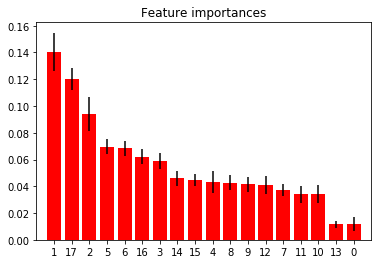

In [80]:
importances = rf_kbest.named_steps.rf.feature_importances_
feature_idx = rf_kbest.named_steps.kbest.get_support()
features = X_train_norm.columns[feature_idx]
plot_feature_importances(rf_kbest.named_steps.rf, importances, features)

## 2. Gaussian Naive Bayes

Try with different types of datasets.

In [11]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
train_pred = gnb.predict(X_train)
test_pred = gnb.predict(X_test)

print(round(accuracy_score(train_pred, y_train), 4))
print(round(accuracy_score(test_pred, y_test), 4))

0.3482
0.3361


In [12]:
gnb = GaussianNB()
gnb.fit(X_train_norm, y_train)
train_pred = gnb.predict(X_train_norm)
test_pred = gnb.predict(X_test_norm)

print(round(accuracy_score(train_pred, y_train), 4))
print(round(accuracy_score(test_pred, y_test), 4))

0.3482
0.3268


In [13]:
gnb = GaussianNB()
gnb.fit(X_train_dummies, y_train)
train_pred = gnb.predict(X_train_dummies)
test_pred = gnb.predict(X_test_dummies)

print(round(accuracy_score(train_pred, y_train), 4))
print(round(accuracy_score(test_pred, y_test), 4))

0.0785
0.0522


## 3. AdaBoost 

In [15]:
ada = AdaBoostClassifier()
ada.fit(X_train_norm, y_train)
train_pred = ada.predict(X_train_norm)
test_pred = ada.predict(X_test_norm)

print(round(accuracy_score(train_pred, y_train), 4))
print(round(accuracy_score(test_pred, y_test), 4))

0.3981
0.3746


In [19]:
confusion_matrix(y_test, test_pred)

array([[  0,  33,  30,   9,  52],
       [  3, 161, 328,  92, 326],
       [  0, 137, 415, 140, 530],
       [  1,  88, 302, 182, 416],
       [  2,  49, 173, 102, 927]], dtype=int64)

NameError: name 'train' is not defined